<a href="https://colab.research.google.com/github/stbiadmin/myopia/blob/main/image_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Myopia: Inference

#### Setup Code

In [39]:
'''
###uncomment to install non-collab-native libraries (run once)
!pip install ipython ipykernel --upgrade

## Install GCS packages
!pip install --q fsspec
!pip install --q gcsfs

##Install Vectice Python library 
!pip install --q vectice[github]==2.2.3

#install import-ipynb package
!pip install ipynb
'''
# Import the required packages

from vectice import Experiment
from vectice.api.json import ModelType
from vectice.api.json import JobType
from vectice.api.json import JobArtifactType
from vectice.api.json import ModelVersionStatus
from vectice.api.json.artifact_version import VersionStrategy
import logging
import os
logging.basicConfig(level=logging.INFO)

#image and DL libraries
import skimage as sk
import skimage.io as skio
import skimage.color as color
import numpy as np
import matplotlib.pyplot as plt
import random
import asyncio
import cv2
import torch
from scipy import signal
from scipy import misc
from scipy import interpolate
from scipy import ndimage
from skimage.transform import resize
import os

import classes

In [ ]:
#mount google drivce
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
#set the path to the source dataset
path = '/content/drive/MyDrive/Vectice Demos/Myopia/data/'
#set path to sample dataset
sample_path = '/content/drive/MyDrive/Vectice Demos/Myopia/sample_images/'
#set path to cropped sample dataset
degraded_path = '/content/drive/MyDrive/Vectice Demos/Myopia/degraded_sample/'

## Pretrained Model Setup

In [24]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

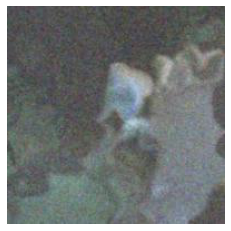

In [23]:
#display a sample degraded image 
img2_path = degraded_path+ random.sample(os.listdir(degraded_path),1)[0]
img2 = plt.imread(img2_path)
plt.imshow(img2)
plt.axis('off')
plt.show()

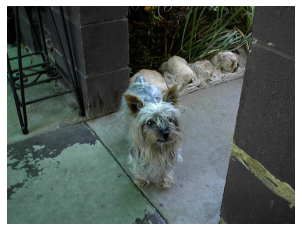

In [33]:
#display a specific image from the undegraded sample dataset
img1_path = sample_path + 'ILSVRC2012_val_00004354_n02096294.JPEG'
img1 = plt.imread(img1_path)
plt.imshow(img1)
plt.axis('off')
plt.show()

In [47]:
#check GT label
classes.IMAGENET2012_CLASSES[test_filename[24:33]]

'Australian terrier'

In [56]:
classes.IMAGENET2012_CLASSES['n01614925'].split(',')[0]

'bald eagle'

In [ ]:
# We create our second experiment for modeling and specify the workspace and the project we will be working on
# Each experiment only contains one job. Each invokation of the job is called a run.
# autocode = True enables you to track your git changes for your code automatically every time you execute a run (see below).
experiment = Experiment(job="Model Setup", project=project_id, job_type=JobType.TRAINING, auto_code=True)

In [ ]:
#add variable for sample data
sample_data = experiment.add_dataset_version(dataset="Degraded Dog v2", version_strategy=VersionStrategy.AUTOMATIC)

In [ ]:
# we declare the dataset versions and code to use as input of our run
experiment.start(inputs=[input_code, sample_data, sample_data],
                run_properties={"Degraded Data": True , "Model" : 'inception_v3'})

Run(id=15917, job=Job(name=Model Setup, id=9557, description=None, type=JobType.TRAINING), name=Run 2022-05-29T21:28:20.228002, system_name=None, start_date=2022-05-29 21:28:21.512283, end_date=None, duration=None, status=RunStatus.STARTED, inputs=[ArtifactReference(code=None, dataset=Degraded Dog, model=None, version_number=None, version_id=None, version_name=None, version_strategy=VersionStrategy.AUTOMATIC, description=None, ), ArtifactReference(code=1001, dataset=None, model=None, version_number=None, version_id=2572, version_name=None, version_strategy=None, description=None, )], outputs=[])

In [34]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
sample = img1_path
input_image = Image.open(sample)
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
  output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
#print(probabilities)

In [35]:
#if the "labels" folder doesn't exist, create it
if not os.path.exists('../content/labels/'):
  os.mkdir('../content/labels/')
else:
  print('labels folder already exists, skipping...')
# Download ImageNet labels
!wget -P /content/labels/ https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt /content/labels
# Download ImageNet-1K GT validation labels 


labels folder already exists, skipping...
--2022-06-04 22:02:06--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘/content/labels/imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-06-04 22:02:06 (95.9 MB/s) - ‘/content/labels/imagenet_classes.txt.1’ saved [10472/10472]

/content/labels: Scheme missing.
FINISHED --2022-06-04 22:02:06--
Total wall clock time: 0.1s
Downloaded: 1 files, 10K in 0s (95.9 MB/s)


In [36]:
# Read the categories
with open("/content/labels/imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

Yorkshire terrier 0.5118944048881531
silky terrier 0.2819816768169403
Australian terrier 0.08489130437374115
cairn 0.018648143857717514
Tibetan terrier 0.002998633310198784


In [40]:
categories[top5_catid[0]]

'Yorkshire terrier'

In [ ]:
#check to see if the labels match


In [ ]:
metrics = {"Prediction" : categories[top5_catid[0]], "Confidence": top5_prob[0].item() }

In [ ]:
model_version = experiment.add_model_version(model="Object Classifier", algorithm="Inception_v3")

In [ ]:
# We complete the current experiment's run 
## The created model version will be automatically attached as output of the run
experiment.complete()